# Feature selection and feature engineering

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import scipy.linalg as sp_la

## Data

Today we will keep working with the set of Craigslist listings for used cars.

All of this section is *exactly the same* as Wednesday and Friday.

First I make my converters.

In [2]:
# these will be our columns
columns = ["price", "year", "manufacturer", "model", "condition", "fuel", "odometer", "title_status", "transmission"]
# this will contain our converters
colValues = {}

# first we load our data as strings so we can define the converters
data = np.array(np.genfromtxt('data/vehicles.csv', delimiter=',', usecols=(1,2,3,4,5,7,8,9,11), skip_header=1, dtype=str, encoding='utf-8'))  

# make a list of the unique values in each column of our data
for colIndex in range(data.shape[1]):
    colValues[colIndex] = np.unique(data[:, colIndex]).tolist()
    print(colIndex, colValues[colIndex])

# fix up some of these ones we know are ordered
colValues[columns.index('condition')] = ['new', 'like new', 'excellent', 'good', 'fair', 'salvage']
colValues[columns.index('title_status')] = ['clean', 'lien', 'rebuilt', 'salvage', 'parts only', 'missing']

# map values to their indices in the list of unique values
def converter(x, colIndex):
    return colValues[colIndex].index(x)

0 ['0', '1', '1000', '10000', '10199', '10200', '10300', '10399', '10400', '10450', '10475', '10488', '10491', '10494', '10495', '10498', '10500', '10550', '10600', '10650', '10691', '10695', '10700', '10800', '10844', '10888', '10900', '10950', '10977', '10980', '10988', '10989', '10990', '10995', '10999', '11000', '11011', '11200', '11250', '11272', '11375', '11380', '11450', '11480', '11493', '11495', '11499', '1150', '11500', '11515', '11550', '11600', '11700', '11795', '11900', '11901', '1195', '11950', '11976', '11985', '11987', '11988', '11990', '11995', '11997', '11999', '1200', '12000', '12177', '12250', '12400', '12450', '12488', '12495', '12499', '1250', '12500', '12588', '12595', '1275', '12775', '12835', '12875', '12889', '12900', '1295', '12950', '12977', '12990', '12995', '12999', '1300', '13000', '13299', '13300', '13325', '13400', '13440', '13450', '13488', '13490', '13494', '13495', '13500', '13599', '13600', '13650', '13750', '13753', '13795', '13850', '13860', '1388

Now we actually load the data.

In [3]:
data = np.array(np.genfromtxt('data/vehicles.csv', delimiter=',', usecols=(1,2,3,4,5,7,8,9,11), converters={3: lambda x: converter(x, 2), 4: lambda x: converter(x, 3), 5: lambda x: converter(x, 4), 7: lambda x: converter(x,5), 9: lambda x: converter(x, 7), 11: lambda x: converter(x, 8)}, skip_header=1, dtype=int, encoding='utf-8'))  

Let's get some summary statistics and do a **pairplot** so we can see what's going on.

In [4]:
def getSummaryStatistics(data):
    print("min, max, mean, std per variable")
    return pd.DataFrame([data.min(axis=0), data.max(axis=0), data.mean(axis=0), data.std(axis=0)])

def getShapeType(data):
    print("shape")
    return (data.shape, data.dtype)

print(getSummaryStatistics(data))
print(getShapeType(data))

min, max, mean, std per variable
              0            1         2           3         4         5  \
0      0.000000  1999.000000  0.000000    0.000000  0.000000  0.000000   
1  55000.000000  2021.000000  1.000000  340.000000  5.000000  4.000000   
2   7978.281507  2012.381887  0.445535  159.225142  2.155478  2.012350   
3   5542.906703     3.997048  0.497025   96.160745  0.721220  0.138432   

              6         7         8  
0  0.000000e+00  0.000000  0.000000  
1  9.999999e+06  5.000000  2.000000  
2  1.124405e+05  0.116213  0.886954  
3  2.546163e+05  0.503424  0.424340  
shape
((3158, 9), dtype('int64'))


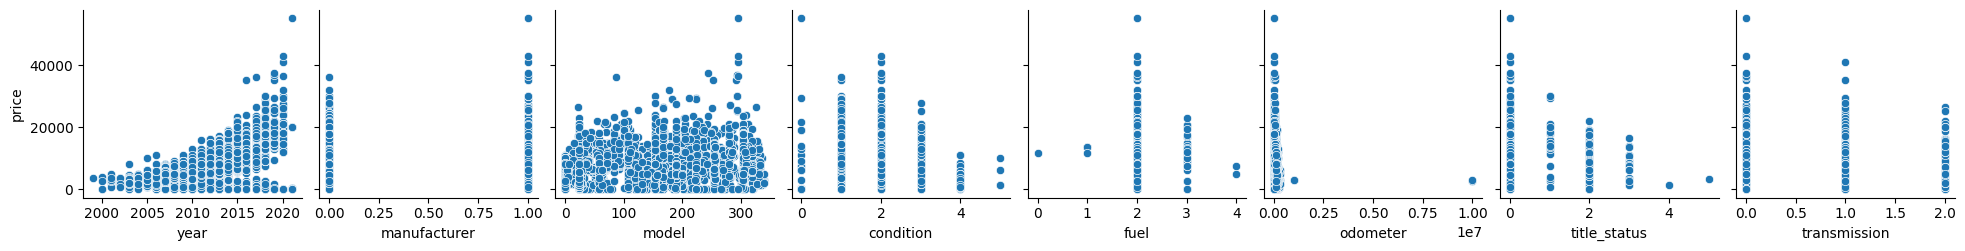

In [5]:
df = pd.DataFrame(data, columns=columns)
seaborn.pairplot(df, y_vars = columns[0], x_vars = columns[1:])

plt.show()

Let's calculate *correlations* between price and the other variables. (Remind me what correlation values vary between?)

In [6]:
for i in range(len(columns)):
    print(columns[i], np.corrcoef(data[:, 0], data[:, i], rowvar=True)[0,1])

price 1.0
year 0.5607406077976831
manufacturer 0.018020904958063123
model 0.12473024847425893
condition -0.24207191464700592
fuel 0.032451877318551946
odometer -0.1272187764664638
title_status 0.005615484666448242
transmission -0.14757003596193927


# Which model is best?

## Stepwise regression

We can do **feature selection**. This is useful for dealing with data that has many variables (features). How do we know which ones to *use*?
Here we do additive feature selection:
* repeatedly add an independent variable, train, and report $R^2$

For stepwise regression we use a modification of $R^2$, $${R^2}_{adj} = 1 - \frac{(1-R^2)(N-1)}{N-k-1}$$
where $N$ is the number of variables, and $k$ is the number of variables in $A$.

Stepwise regression works like this:

1. Initialize $A$ to be just the leading column of 1s (because we know we will have an intercept).

2. Then while the improvements in ${R^2}_{adj}$ are > 0 and there remain independent variables not yet added:
  * calculate a regression using $A$ and each variable not yet in $A$, and 
  * add the one with the highest ${R^2}_{adj}$ to $A$.

We could also do a variant of additive feature selection using the correlations:
* sort independent variables by size of correlation (positive or negative!) with the dependent variable
* repeatedly add the independent variable with the next biggest correlation; if it leads to higher $R^2$, keep it; if it doesn't, drop it again

And we could also go from most features to fewest:
* start with a model fit using *all* independent variables
* repeatedly take an independent variable out; if the resulting model has higher $R^2$, leave that variable out going forward

There are many other options for feature selection!

In this code block, I calculate the *powerset* of all the independent variables. Then, for each subset of the independent variables I train a model and calculate MSSE (on the training data) and $R^2$ (on the test data). Then, I report the ten worst and ten best performing sets of independent variables by MSSE and by $R^2$.

Note:
* sometimes models with fewer variables work better than models with more
* sometimes a model may fit the training data better but the test data worse

### First, split our data

Let's split our data into **train** and **test**. Let's make sure and sort by time first, because we don't want to let the future predict the past.

In [8]:
data = data[data[:, 1].argsort()]
print(getSummaryStatistics(data))
print(getShapeType(data))

(train, test) = np.split(data, [int(len(data) / 10 * 8)])
print(train.shape, test.shape)

min, max, mean, std per variable
              0            1         2           3         4         5  \
0      0.000000  1999.000000  0.000000    0.000000  0.000000  0.000000   
1  55000.000000  2021.000000  1.000000  340.000000  5.000000  4.000000   
2   7978.281507  2012.381887  0.445535  159.225142  2.155478  2.012350   
3   5542.906703     3.997048  0.497025   96.160745  0.721220  0.138432   

              6         7         8  
0  0.000000e+00  0.000000  0.000000  
1  9.999999e+06  5.000000  2.000000  
2  1.124405e+05  0.116213  0.886954  
3  2.546163e+05  0.503424  0.424340  
shape
((3158, 9), dtype('int64'))
(2526, 9) (632, 9)


In [19]:
# x a matrix of multiple independent variables
# poly -> polys, a matrix of multiple polynomial degrees for each column in x in order
def makePoly(x, polys):
    # make an empty array of size A
    A = np.zeros([x.shape[0], np.sum(polys)+1])
    # left most column of 1s for the intercept
    # notice this is also a third way to get that leading column of ones!
    A[:, 0] = np.squeeze(x[:, 0]**0)
    k = 1
    # for each variable
    for (j, poly) in enumerate(polys):
        # for up to and including! poly
        for i in range(1, poly+1):
            A[:, k] = np.squeeze(x[:, j]**i)
            k += 1
    return A

def fit(data, independent, dependent, polys):
    # This is our independent variable, just one for now
    x = data[np.ix_(np.arange(data.shape[0]), independent)]

    # We add the polynomials, and a column of 1s for the intercept
    A = makePoly(x, polys)

    # This is the dependent variable 
    y = data[:, dependent]

    # This is the regression coefficients that were fit, plus some other results
    # We use _ when we don't want to remember something a function returns
    c, _, _, _ = sp_la.lstsq(A, y)
    return c

def predict(data, independent, polys, c):
    # These are our independent variable(s)
    x = data[np.ix_(np.arange(data.shape[0]), independent)]

    # We add the polynomials, and a column of 1s for the intercept
    A = makePoly(x, polys)

    return np.dot(A, c)

def rsquared(y, yhat):
    if len(y) != len(yhat):
        print("Need y and yhat to be the same length!")
        return 0
    return 1 - (((y - yhat)**2).sum() / ((y - y.mean())**2).sum())

In [21]:
from itertools import chain, combinations

def powerset(variables):
    return chain.from_iterable(combinations(variables, r) for r in range(len(variables)+1))

def msse(y, yhat):
    r = (np.square(y - yhat)).mean()
    return r

res = {}
for variableset in powerset(range(1, train.shape[1])):
    if len(variableset) > 0:
        # fit the multiple linear regression
        polys = [1 for x in range(len(variableset))]
        c = fit(train, list(variableset), 0, polys)
        # calculate MSSE and R^2
        res[variableset] = (msse(train[:, 0], predict(train, variableset, polys, c)), 
                            rsquared(test[:, 0], predict(test, variableset, polys, c)))

In [22]:
# sort by R^2
byrsquared = sorted(res.items(), key=lambda item: item[1][1])
print("Worst R^2")
for i in range(10):
    print([columns[x] for x in byrsquared[i][0]], byrsquared[i][1])
print("Best R^2")
for i in range(1, 11):
    print([columns[x] for x in byrsquared[-i][0]], byrsquared[-i][1])

Worst R^2
['fuel', 'title_status'] (15678294.77723844, -0.5257949419324093)
['manufacturer', 'fuel', 'title_status'] (15661174.669323152, -0.5253385602192633)
['fuel'] (15680923.004769573, -0.5248885602561073)
['manufacturer', 'fuel'] (15664008.472552951, -0.5243952125253757)
['title_status'] (15748196.891766587, -0.5225474174355549)
['manufacturer', 'title_status'] (15730243.225175029, -0.5222875590818823)
['manufacturer'] (15733770.848230472, -0.5211212292722571)
['manufacturer', 'model', 'fuel', 'title_status'] (15488991.98672638, -0.5057372643808149)
['model', 'fuel', 'title_status'] (15491918.893379271, -0.5054081576639506)
['manufacturer', 'model', 'fuel'] (15490980.658085302, -0.5049200198041972)
Best R^2
['year', 'manufacturer', 'model', 'odometer', 'transmission'] (10601840.011892483, 0.06419705475377502)
['year', 'manufacturer', 'model', 'odometer', 'title_status', 'transmission'] (10565022.830914525, 0.06402220106625933)
['year', 'manufacturer', 'model', 'transmission'] (106

Bad pipe message: %s [b'Z\x98\xa7\xd7,c\x83\xd0:\xdcmW5\xcd\xd5\x07\xf8\x0f \xa3::|\x96\x8f\xdeV\xa5>\xd2\xf8\x1d8\x9b\t\x96h{\x90\xab\xd4p.q>x\xb4\xfb\x80&\x90\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00\x17\x00\x00\x00\r\x00\x1e\x00\x1c\x04\x03\x05\x03\x06\x03\x08\x07\x08\x08\x08\t\x08\n\x08\x0b', b'\x08\x05\x08\x06\x04\x01\x05']
Bad pipe message: %s [b'']
Bad pipe message: %s [b'N\t=x7\xdd+yJ>\xcez\x90R\xd9\x04B\x85\x00\x00\xa6\xc0,\xc00\x00\xa3\x00\x9f\xcc\xa9\xcc\xa8\xcc\xaa\xc0\xaf\xc0\xad\xc0\xa3\xc0\x9f\xc0]\xc0a\xc0W\xc0S\xc0+\xc0/\x00\xa2\x00\x9e\xc0\xae\xc0\xac\xc0\xa2\xc0\x9e\xc0\\\xc0`\xc0V\xc0R\xc0$\xc0(\x00k\x00j\xc0s\xc0w\x00\xc4\x00\xc3\xc0#\xc0', b'g\x00@\xc0r\xc0v\x00\xbe\x00\xbd\xc0\n\xc0\x14\x009\x008\x00\x88\x00\x87\xc0\t\xc0\x13\x003\x002\x00\x9a\x00\x99\x00E\x00']
Bad pipe message: %s 

In [23]:
# sort by MSSE
bymsse = sorted(res.items(), key=lambda item: item[1][0])
print("Worst MSSE")
for i in range(1, 11):
    print([columns[x] for x in bymsse[-i][0]], bymsse[-i][1])
print("Best MSSE")
for i in range(10):
    print([columns[x] for x in bymsse[i][0]], bymsse[i][1])


Worst MSSE
['title_status'] (15748196.891766587, -0.5225474174355549)
['manufacturer'] (15733770.848230472, -0.5211212292722571)
['manufacturer', 'title_status'] (15730243.225175029, -0.5222875590818823)
['transmission'] (15700812.08185249, -0.4987867737388707)
['title_status', 'transmission'] (15699169.535512554, -0.49986484589737956)
['manufacturer', 'transmission'] (15682068.624579087, -0.49827385653343925)
['fuel'] (15680923.004769573, -0.5248885602561073)
['manufacturer', 'title_status', 'transmission'] (15680271.539479375, -0.49940195430354106)
['fuel', 'title_status'] (15678294.77723844, -0.5257949419324093)
['manufacturer', 'fuel'] (15664008.472552951, -0.5243952125253757)
Best MSSE
['year', 'manufacturer', 'model', 'condition', 'fuel', 'odometer', 'title_status', 'transmission'] (10376390.694121888, 0.06200773752218314)
['year', 'manufacturer', 'model', 'condition', 'fuel', 'title_status', 'transmission'] (10377034.279797869, 0.061873212381249765)
['year', 'manufacturer', 'mod

# Feature engineering

When we fiddle with our independent variables to make the models better, we call this **feature engineering**. For example, adding the square of age.

So we have two ways to experiment with a single modeling approach:
* feature selection
* feature engineering

I would not call data transformations (like max-min normalization) feature engineering, since you should do them before you start modeling, but you might choose to consider them feature engineering.

In real-world projects, you can spend a huge amount of time doing feature selection and feature engineering. It can get overwhelming quickly! Keep good track of your work through either an experiment logbook, or experiment tracking software like [weights and biases](https://wandb.ai/site).

# Review

1. Find some data!
2. Load and look at your data
  * thing1
  * thing2
3. Consider cleaning, transforming and/or normalizing your data
  * thing1
  * thing2
  * thing3
  * thing4
4. Look at your data some more and consider feature selection, feature engineering, dimensionality reduction
  * *correlations*
  * *covariance matrix*
  * *PCA*
5. Model
  * thing1 (in three variations!)